In [19]:
import sys
sys.path.append("./PatchTST_self_supervised/")
from types import SimpleNamespace
import xarray as xr
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np


from PatchTST_self_supervised.src.models.patchTST import PatchTST
from PatchTST_self_supervised.src.learner import Learner, transfer_weights
from PatchTST_self_supervised.src.callback.tracking import *
from PatchTST_self_supervised.src.callback.patch_mask import *
from PatchTST_self_supervised.src.callback.transforms import *
from PatchTST_self_supervised.src.metrics import *
from PatchTST_self_supervised.src.basics import set_device
from PatchTST_self_supervised.datautils import *

from src.data.datamodule import DataLoaders


## Dataset and Dataloader

In [20]:
PATH = "./"

ds_full = xr.open_zarr("s3://wfp-ops-userdata/public-share/ndvi_world.zarr")

new_time_chunk_size = -1
new_latitude_chunk_size = 50
new_longitude_chunk_size = 50
target_chunks = {'time':
                 new_time_chunk_size, 'latitude': new_latitude_chunk_size, 'longitude': new_longitude_chunk_size}

max_mem = "12GB"

time_step_size = 30  # Define batch size
num_batches = ds_full.dims['time'] // time_step_size


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'NDVI Rechunked/ndvi_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

NDVI = xr.concat(concatenated_ds_list, dim='time')


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'RFH Rechunked/rfh_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

# Concatenate all datasets along the time dimension
RFH = xr.concat(concatenated_ds_list, dim='time')


In [21]:
bbox_africa = [-17.314453,-34.957995,51.855469,13.667338]

# +
NDVI_africa =NDVI.sel(
    latitude=slice(bbox_africa[3], bbox_africa[1]),
    longitude=slice(bbox_africa[0], bbox_africa[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)


RFH_africa =RFH.sel(
    latitude=slice(bbox_africa[3], bbox_africa[1]),
    longitude=slice(bbox_africa[0], bbox_africa[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)


This method typically involves training the model for a few epochs with a range of learning rates and recording the loss at each step. The learning rate that gives the fastest decrease in loss is considered optimal or near-optimal for the training process.

# Finetune

In [22]:
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 3e-4,
    
    'batch_size':64, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 200, # number of pre-training epochs
    'n_epochs_finetune' : 50, # number of pre-training epochs
    'pretrained_model_id': 1, # id of the saved pretrained model
    
    
    'save_finetuned_model': './finetuned',
    
    'save_path' :  'saved_models' + '/masked_patchtst/'
    
}

config_obj = SimpleNamespace(**config)

In [23]:
class Rain_Ndvi_Dataset(Dataset):
    def __init__(self, ndvi_array, rfh_array,time_array, lat_index,lon_index, size=None, split='train', scale=True):
        if size is None:
            self.seq_len = 30
            self.label_len = 10
            self.pred_len = 10
        else:
            self.seq_len, self.label_len, self.pred_len = size
            
        assert split in ['train', 'val', 'test']
        self.split = split
        self.scale = scale
        # self.ndvi_xarray = ndvi_xarray
        # self.rfh_xarray = rfh_xarray
        self.ndvi_array = ndvi_array
        self.rfh_array = rfh_array
        self.time_array = time_array
        self.features = ['rfh', 'ndvi']
        self.lat_index = lat_index
        self.lon_index = lon_index


        self.initialize_data_for_epoch()

    def initialize_data_for_epoch(self):
        # Randomly select a pixel
        lat, lon = self.select_random_pixel()
        
        # while np.isnan(self.ndvi_xarray.isel(latitude=lat, longitude=lon, time=0).band.values) or np.isnan(self.rfh_xarray.isel(latitude=lat, longitude=lon, time=0).band.values):
        #     lat, lon = self.select_random_pixel()
        # Generate DataFrame for the selected pixel
        # if self.split == "test":
        #     print("(lat, lon) selected for test:",  (lat, lon))
            
        self.dataframe = self.generate_pixel_dataframe(lat, lon)
        # Read and split data
        self.__read_data__()

    def select_random_pixel(self):
        lat = self.lat_index
        lon = self.lon_index
        return lat, lon

    def generate_pixel_dataframe(self, lat, lon):
        ndvi_df = pd.DataFrame(self.ndvi_array[:,lat,lon], columns=['band'])
        time_values = self.time_array  
        ndvi_df = ndvi_df.reset_index()
        ndvi_df['time'] = time_values
        ndvi = ndvi_df[['time', 'band']]
        ndvi.rename(columns={'band': 'ndvi'}, inplace=True)
        ndvi.set_index('time', inplace=True)
        
        
        rfh_df = pd.DataFrame(self.rfh_array[:,lat,lon], columns=['band'])
        time_values = self.time_array  
        rfh_df = rfh_df.reset_index()
        rfh_df['time'] = time_values
        rfh = rfh_df[['time', 'band']]
        rfh.rename(columns={'band': 'rfh'}, inplace=True)
        rfh.set_index('time', inplace=True)
        df = pd.concat([rfh, ndvi], axis=1)
        return df

    def __read_data__(self):
        df = self.dataframe.copy()

        if self.scale:
            self.scaler = StandardScaler()
            df[self.features] = self.scaler.fit_transform(df[self.features])
            

        train_size = int(0.7 * len(df))
        val_size = int(0.15 * len(df))

        if self.split == 'train':
            self.data = df.iloc[:train_size]
        elif self.split == 'val':
            self.data = df.iloc[train_size:train_size + val_size]
        else:
            self.data = df.iloc[train_size + val_size:]

    def __getitem__(self, index):
        # Choose a random start index for the sequence
        max_start_index = len(self.data) - self.seq_len - self.pred_len
        if max_start_index < 1:
            raise ValueError("Dataset is too small for the specified sequence and prediction lengths.")
        random_start = np.random.randint(0, max_start_index)

        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end 
        r_end = r_begin + self.pred_len
        

        seq_x = self.data.iloc[s_begin:s_end][self.features].values
        seq_y = self.data.iloc[r_begin:r_end][self.features].values


        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        if self.scale:
            return self.scaler.inverse_transform(data)
        return data

In [24]:
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 3e-4,
    
    'batch_size':128, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 200, # number of pre-training epochs
    'n_epochs_finetune' : 50, # number of pre-training epochs
    'pretrained_model_id': 1, # id of the saved pretrained model
    
    
    'save_finetuned_model': './finetuned_d128',
    
    'save_path' :  'saved_models' + '/masked_patchtst/'
    
}

config_obj = SimpleNamespace(**config)

def get_model(args, head_type, weight_path=None):
    """
    c_in: number of variables
    """
    # get number of patches
    num_patch = (max(args.sequence_length, args.patch_len)-args.patch_len) // args.stride + 1    
    print('number of patches:', num_patch)
    
    # get model
    model = PatchTST(c_in=args.c_in,
                target_dim=args.prediction_length,
                patch_len=args.patch_len,
                stride=args.stride,
                num_patch=num_patch,
                n_layers=4, #number of Transformer layers
                n_heads=16,#number of Transformer heads
                d_model= 128, #128, #Transformer d_model
                shared_embedding=True,
                d_ff=512, #Tranformer MLP dimension                              
                dropout=2e-1, #Transformer dropout
                head_dropout=2e-1, #head dropout
                act='relu',
                head_type=head_type,
                res_attention=False
                )    
    if weight_path: model = transfer_weights(weight_path, model)
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model

ndvi_array = NDVI_africa.band.values
rfh_array = RFH_africa.band.values
time_array = RFH_africa.time.values

def get_dls(config_obj, dataset_class,lat,lon):
    size = [config_obj.sequence_length, 0, config_obj.prediction_length]
    dls = DataLoaders(
            datasetCls=dataset_class,
            dataset_kwargs={
                'ndvi_array':ndvi_array , 
                'rfh_array':rfh_array ,
                'time_array':time_array ,
                'size':size,
                'scale':True,
                'lat_index': lat,
                'lon_index': lon
            },
            batch_size=config_obj.batch_size,
            workers=config_obj.num_workers,
            )

    dls.vars, dls.len = dls.train.dataset[0][0].shape[1], config_obj.sequence_length
    dls.c = dls.train.dataset[0][1].shape[0]
    return dls

In [25]:
model = get_model(config_obj, head_type='prediction').to('cpu')
model = transfer_weights("saved_models/masked_patchtst/finetuned_d128.pth", model)


def get_embedding(model,input_sequence):
   
    # Verify the shape of input_sequence
    # Unfold to create patches
    input_sequence = input_sequence.unfold(0, config_obj.patch_len, config_obj.stride)

    # Rearrange dimensions to [num_patch, patch_len, n_vars]
    # input_sequence = input_sequence.permute(1, 2, 0)

    # Add batch dimension to get [bs, num_patch, n_vars, patch_len]
    input_sequence = input_sequence.unsqueeze(0)

    # Verify the reshaped input sequence

    # Ensure the tensor is on the correct device
    input_sequence = input_sequence.to('cpu')

    # Perform the forward pass
    with torch.no_grad():
        encoder_output = model.capture_embedding(input_sequence) # embedding now has the shape [bs x nvars x d_model x num_patch]
        
    return encoder_output




number of patches: 7
number of model params 802825
weights from saved_models/masked_patchtst/finetuned_d128.pth successfully transferred!



In [26]:
def eigenvalues(embedding):

    A = embedding.squeeze(0).view(2, -1) 

    AtA = torch.mm(A, A.t())

    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eig(AtA)


    eigenvalues = eigenvalues.numpy()
    eigenvectors = eigenvectors.numpy()

    return eigenvalues 

# For a whole region of Mozambique

In [61]:
print(ndvi_array.shape)

torch.zeros(NDVI_africa.band.shape[1], NDVI_africa.band.shape[2])[::5,::5].shape

(720, 195, 277)


torch.Size([39, 56])

In [67]:

# Initialize Embeddings_map with reduced size
Embeddings_map = torch.zeros(NDVI_africa.band.shape[1], NDVI_africa.band.shape[2])[::5, ::5]

# Adjust the for loops to iterate over the reduced dimensions of Embeddings_map
for latitude in range(Embeddings_map.shape[0]):
    for longitude in range(Embeddings_map.shape[1]):
        
        # Calculate the actual latitude and longitude indices
        actual_lat = latitude * 5
        actual_lon = longitude * 5

        # Retrieve the input sequence using the actual indices
        input_sequence = get_dls(config_obj, Rain_Ndvi_Dataset, actual_lat, actual_lon).test.dataset[index][0]
        embedding = get_embedding(model, input_sequence)

        if np.isnan(embedding[0, 0, 0, 0]):
            Embeddings_map[latitude, longitude] = np.nan
        else:
            Embeddings_map[latitude, longitude] = torch.tensor((eigenvalues(embedding)[0] * eigenvalues(embedding)[1]).real, dtype=torch.float32)


In [69]:

# Initialize Embeddings_map with reduced size
Embeddings_map = torch.zeros(NDVI_africa.band.shape[1], NDVI_africa.band.shape[2])

# Adjust the for loops to iterate over the reduced dimensions of Embeddings_map
for latitude in range(Embeddings_map.shape[0]):
    for longitude in range(Embeddings_map.shape[1]):
        
        # Calculate the actual latitude and longitude indices
        actual_lat = latitude 
        actual_lon = longitude 

        # Retrieve the input sequence using the actual indices
        input_sequence = get_dls(config_obj, Rain_Ndvi_Dataset, actual_lat, actual_lon).test.dataset[index][0]
        embedding = get_embedding(model, input_sequence)

        if np.isnan(embedding[0, 0, 0, 0]):
            Embeddings_map[latitude, longitude] = np.nan
        else:
            Embeddings_map[latitude, longitude] = torch.tensor((eigenvalues(embedding)[0] * eigenvalues(embedding)[1]).real, dtype=torch.float32)



KeyboardInterrupt



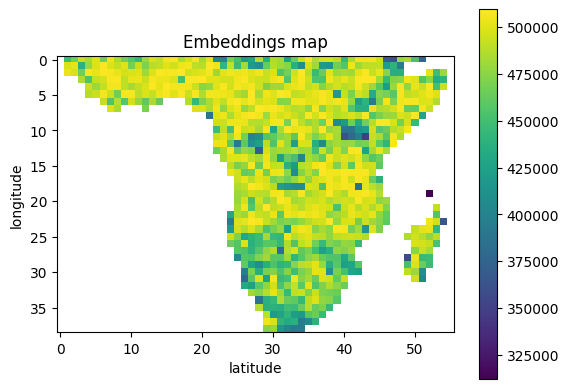

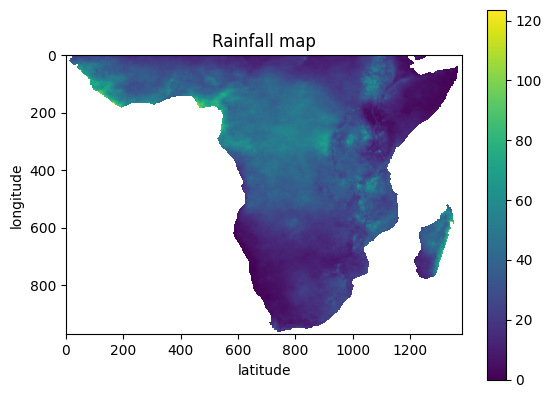

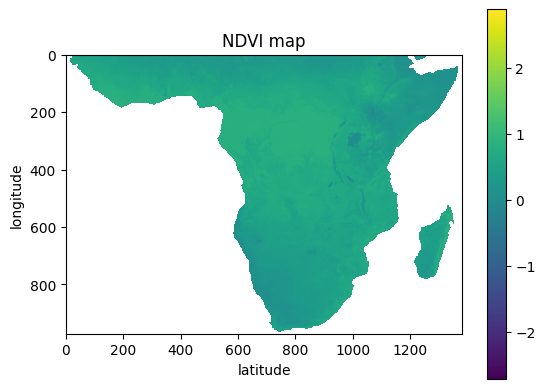

In [68]:
plt.imshow(Embeddings_map)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Embeddings map: eigenvalues")
plt.colorbar()
plt.show()

plt.imshow(RFH_selected_region.mean(axis=0))
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Rainfall map")
plt.colorbar()

plt.show()

plt.imshow(NDVI_selected_region.mean(axis=0))
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("NDVI map")
plt.colorbar()

In [28]:
index=15
NDVI_africa.time[index].values

numpy.datetime64('2002-12-01T00:00:00.000000000')

In [53]:
# This is an example assuming you have a list of embedding tensors
embeddings_list = []  # replace with your actual list of tensors
time_series_list = []  # replace with your actual list of tensors

for lat in range(0,NDVI_africa.band.shape[1],20):
    for lon in range(0,NDVI_africa.band.shape[2],5):
        
        ds=
        input_sequence = get_dls(config_obj, Rain_Ndvi_Dataset, lat, lon).test.dataset[index][0];
        time_series_list.append(get_dls(config_obj, Rain_Ndvi_Dataset, lat, lon).test.dataset.inverse_transform(input_sequence))
        if not(np.isnan(input_sequence[0,0])):

            embedding = get_embedding(model, input_sequence)
            # This is an example assuming you have a list of embedding tensors
            embeddings_list.append(embedding)# replace with your actual list of tensors

            # Stack embeddings to create a dataset with multiple samples
            # Each embedding should have the shape [1, 2, 128, 7]
stacked_embeddings = torch.vstack(embeddings_list)



In [73]:
NDVI_africa.isel(time=719,latitude=NDVI_africa.band.shape[1]//2, longitude=NDVI_africa.band.shape[2]//2)

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    latitude     float64 -10.63
    longitude    float64 17.23
    spatial_ref  int32 0
    time         datetime64[ns] 2022-06-21
Data variables:
    band         float64 dask.array<chunksize=(), meta=np.ndarray>

# distance between embeddings

In [56]:
index=10
# Initialize Embeddings_map with reduced size
Embeddings_distance = torch.zeros(NDVI_africa.band.shape[1], NDVI_africa.band.shape[2])[::5,::5]

ref_embedding = get_embedding(model,get_dls(config_obj, Rain_Ndvi_Dataset, NDVI_africa.band.shape[1]//2, NDVI_africa.band.shape[2]//2).test.dataset[index][0])

# Adjust the for loops to iterate over the reduced dimensions of Embeddings_map
for latitude in range(Embeddings_distance.shape[0]):
    for longitude in range(Embeddings_distance.shape[1]):
        
        # Calculate the actual latitude and longitude indices
        actual_lat = latitude*5
        actual_lon = longitude *5

        # Retrieve the input sequence using the actual indices
        input_sequence = get_dls(config_obj, Rain_Ndvi_Dataset, actual_lat, actual_lon).test.dataset[index][0]
        embedding = get_embedding(model, input_sequence)

        if np.isnan(embedding[0, 0, 0, 0]):
            Embeddings_distance[latitude, longitude] = np.nan
        else:
            Embeddings_distance[latitude, longitude] = torch.linalg.norm(embedding - ref_embedding)

In [92]:
# Convert original_coordinates to a numpy array if it's not already
original_coordinates_np = original_coordinates.numpy()

# Initialize lat_long as a numpy array
lat_long = np.zeros_like(original_coordinates_np, dtype=float)

for i in range(lat_long.shape[0]):
    lat_index = original_coordinates_np[i, 0]
    lon_index = original_coordinates_np[i, 1]
    lat_long[i, 0] = NDVI_africa.latitude[lat_index]
    lat_long[i, 1] = NDVI_africa.longitude[lon_index]

# Now lat_long should contain the latitude and longitude values
print(lat_long)

[[ 13.625 -16.025]
 [ 13.625 -14.775]
 [ 13.625 -13.525]
 ...
 [-33.875  22.725]
 [-33.875  23.975]
 [-33.875  25.225]]


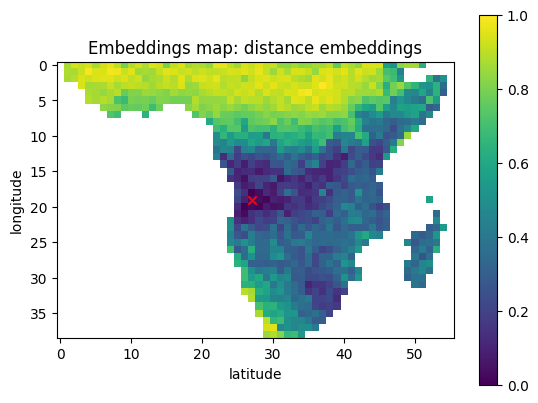

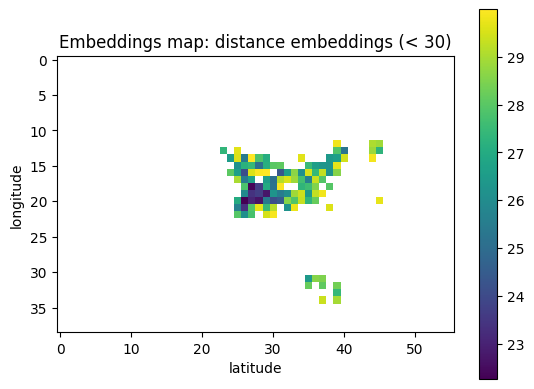

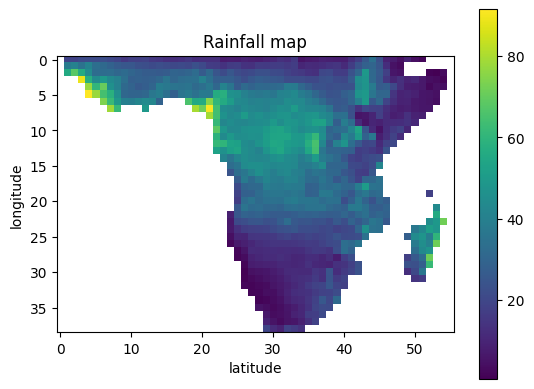

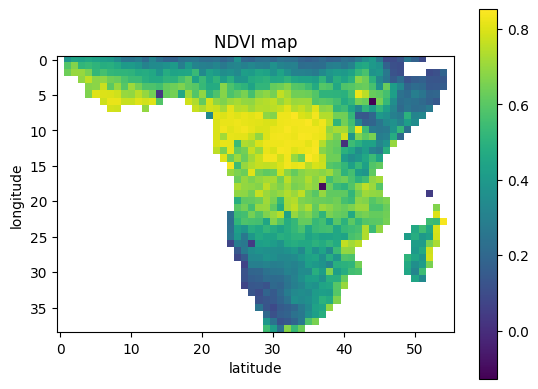

In [74]:
plt.imshow(Embeddings_distance)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.scatter(NDVI_africa.band.shape[2]//2//5, NDVI_africa.band.shape[1]//2//5, color="r", marker="x")
plt.title("Embeddings map: distance embeddings")
plt.colorbar()
plt.show()


# Mask the values greater than or equal to 30
masked_embeddings_distance = np.ma.masked_where(Embeddings_distance >= 30, Embeddings_distance)

# Plot the embeddings distance map with the mask
plt.imshow(masked_embeddings_distance, cmap='viridis')  # You can choose a colormap that suits your data
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Embeddings map: distance embeddings (< 30)")
plt.colorbar()
plt.show()



plt.imshow(rfh_array.mean(axis=0)[::5,::5])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Rainfall map")
plt.colorbar()

plt.show()

plt.imshow(ndvi_array.mean(axis=0)[::5,::5])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("NDVI map")
plt.colorbar()

# PCA

In [31]:
len(time_series_list)

560

In [36]:
stacked_embeddings = torch.vstack(embeddings_list)

# Now reshape the stacked embeddings to a 2D array for PCA
bs, nvars, d_model, num_patch = stacked_embeddings.shape
embeddings_2d = stacked_embeddings.view(bs, -1).numpy()

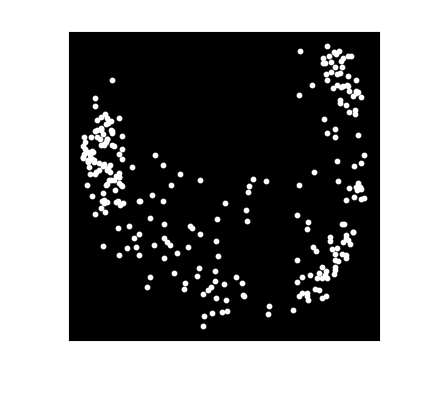

In [55]:
fig, ax = plt.subplots(figsize=(4,4), facecolor="None")
ax.scatter(pca_results[:, 0], pca_results[:, 1], s=10, color='white')
ax.set_title('PCA Visualization of Climatological Embeddings', color='white')
ax.set_xlabel('PCA Component 1', color='white')
ax.set_ylabel('PCA Component 2', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('black')
plt.show()

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ipywidgets import widgets, Output, HBox, VBox
from IPython.display import display

# Perform PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings_2d)

# Prepare the output widgets to display plots
pca_output = Output()
ndvi_output = Output()

# Function to update the NDVI plot with the selected point
def update_ndvi_plot(index):
    # Plot the NDVI time series in its output widget
    with ndvi_output:
        ndvi_output.clear_output(wait=True)
        # Set the facecolor to black and line color to white for NDVI plot
        fig, ax = plt.subplots(figsize=(3,3), facecolor="None")
        ax.plot(time_series_list[index][:,1], color='white')
        ax.set_title("NDVI Time Series", color='white')
        ax.set_xlabel('Time', color='white')
        ax.set_ylabel('NDVI Value', color='white')
        ax.grid(True, color='white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.set_facecolor('black')
        plt.show()

# Function to update the PCA plot with the selected point
def update_pca_plot(index):
    # Plot the PCA plot in its output widget
    with pca_output:
        pca_output.clear_output(wait=True)
        # Set the facecolor to black for PCA plot
        fig, ax = plt.subplots(figsize=(4,4), facecolor="None")
        ax.scatter(pca_results[:, 0], pca_results[:, 1], s=10, color='white')
        ax.scatter(pca_results[index, 0], pca_results[index, 1], s=50, color='red')
        ax.set_title('PCA Visualization of Climatological Embeddings', color='white')
        ax.set_xlabel('PCA Component 1', color='white')
        ax.set_ylabel('PCA Component 2', color='white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.set_facecolor('black')
        plt.show()

# Create slider widget
index_slider = widgets.IntSlider(min=0, max=len(time_series_list) - 1, step=1, value=0, description='Index')

# When the value of the slider changes, update both plots
def on_slider_change(change):
    index = change['new']
    update_pca_plot(index)
    update_ndvi_plot(index)

index_slider.observe(on_slider_change, names='value')

# Create a horizontal box to hold the slider and PCA output widget
slider_and_pca = HBox([index_slider, pca_output])

# Display the slider and PCA output widget side by side and NDVI output below
display(VBox([slider_and_pca, ndvi_output]))

# Initially update both plots with the first index
update_pca_plot(0)
update_ndvi_plot(0)


**PCA Component 1**:

This is the direction along which there's the most variance. If Component 1 correlates strongly with either rainfall or NDVI, it might be representing a gradient of that variable. For example, if Component 1 is heavily weighted on rainfall, points further to the right might correspond to higher rainfall scenarios.

**PCA Component 2**:

This is the direction capturing the second most variance and is orthogonal to Component 1. If this component has a strong correlation with one of the variables not captured by Component 1, it represents another dimension of variation. For instance, if NDVI is not well represented in Component 1, Component 2 might be capturing the variance in vegetation health

In [121]:
data= get_dls(config_obj, Rain_Ndvi_Dataset, 35, 100).test.dataset[index][0]
data.shape

torch.Size([36, 2])

In [122]:
# Assuming you have fitted PCA as follows:
pca = PCA(n_components=2)
pca.fit(data)  # 'data' is your original data with rainfall and NDVI

# The loadings are the components_ attribute of the fitted PCA object
loadings = pca.components_.T  # Transpose to align with the original variables

# Now 'loadings' is a 2D array with the same number of rows as original variables
# and columns corresponding to the PCA components

# For example, if you have two variables, you will have a 2x2 loadings matrix
print("Loadings matrix:\n", loadings)

# Analyze the loadings for each variable with respect to each component
rainfall_loadings = loadings[0]
ndvi_loadings = loadings[1]

print("Rainfall loadings for Component 1 and Component 2:", rainfall_loadings)
print("NDVI loadings for Component 1 and Component 2:", ndvi_loadings)


Loadings matrix:
 [[-0.59794124  0.80153994]
 [-0.80153994 -0.59794124]]
Rainfall loadings for Component 1 and Component 2: [-0.59794124  0.80153994]
NDVI loadings for Component 1 and Component 2: [-0.80153994 -0.59794124]


# T-SNE

Explained variance by 50 PCA components: 0.83


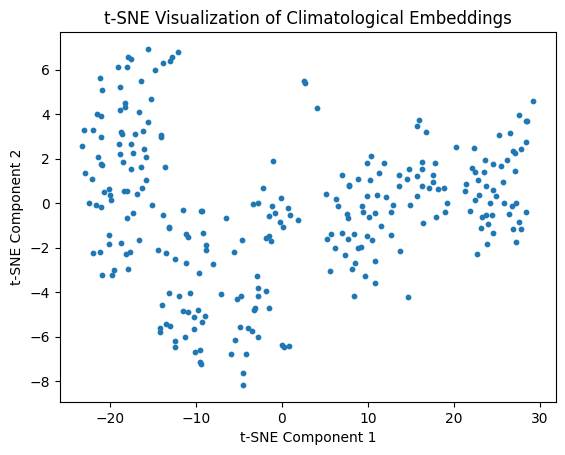

In [125]:
from sklearn.manifold import TSNE

# Your stacked_embeddings tensor is ready to be used for t-SNE
stacked_embeddings = torch.vstack(embeddings_list)

# Reshape the stacked embeddings to a 2D array
bs, nvars, d_model, num_patch = stacked_embeddings.shape
embeddings_2d = stacked_embeddings.view(bs, -1).numpy()

# Perform PCA to reduce dimensionality before t-SNE 
pca = PCA(n_components=50)  # Reduce to 50 components for faster t-SNE computation
pca_result = pca.fit_transform(embeddings_2d)
print(f"Explained variance by 50 PCA components: {np.sum(pca.explained_variance_ratio_):.2f}")

# Perform t-SNE on the PCA-reduced data
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(pca_result)

# Plot the t-SNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10)
plt.title('t-SNE Visualization of Climatological Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
